## Data Generator

In this notebook, we provide the code for generating microbial communities for varying initial conditions. These will then be used to trained variational autoencoders for later generative tasks, namely predicting dynamics from initial conditions. 

As usual, we begin by importing numerical simulation libraries. 

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from sklearn.model_selection import train_test_split

First we define the ODE model of interest. We use our previous model for community dynamics:

$$
\dfrac{dp_i}{dt} = \mu_i\,p_i\,\left(1-p_i-\dfrac{\sigma}{1+\sum \gamma_{ij}^+ p_j} + \sum \gamma_{ij}^-p_j\right)
$$


In [3]:
def multi_species_model(p,t,  n , Gamma, sigma, mu):


    # We must construct a list of n elements, each corresponding to the growth derivative of each species
    dpdt = np.zeros(n)
    
    # Pull off all positive interactions and negative interactions
    Gamma_pos = Gamma*(Gamma > 0)
    Gamma_neg = Gamma*(Gamma < 0)
    
    # Compute the current value of the net positive and negative interaction terms
    gamma_pos = Gamma_pos @ p
    gamma_neg = Gamma_neg @ p
    
    # Compute the derivative term in vectorized form
    dpdt = mu * p * ( np.ones(n) - p - sigma/(np.ones(n)+gamma_pos)  + gamma_neg )
    
    return dpdt

### Simulating 2 Member Communities Data

For a first proof of principle, we simulate a simple 2-member community with a randomly generated interaction matrix and growth rate. 

In [64]:
N = 2
mu = np.random.rand(N)
gamma = np.random.randn(N,N)
sigma = 0.05
p0 = 0.05*np.ones(N)
time_range = np.linspace(0,20,30)

Now we will sample data points on the uniform unit cube in 2D:

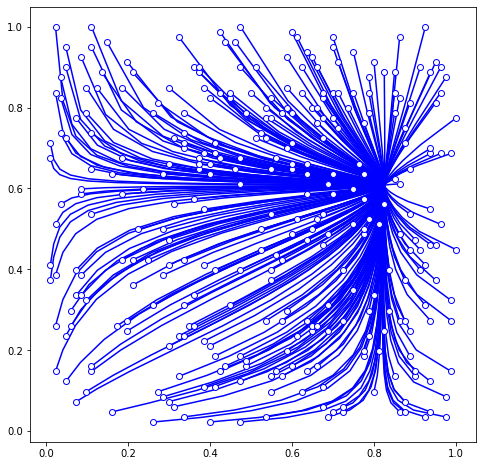

In [71]:
def gen_2D_dataset():
    # Plot results
    fig = plt.figure(figsize = (8,8))
    ax = fig.add_subplot(111)
    #ax = plot_style(ax)

    data = []
    for i in np.linspace(0.01,1.0, 80):
        for j in np.linspace(0.01,1.0, 80):

            p0 = [i, j]
            sol = odeint(multi_species_model,  p0, time_range, args = (N,gamma, sigma, mu, )).T
            
            # Plot on average 10% of the curves for visualization
            if np.random.rand(1) < 0.05:
                plt.plot(sol[0,:], sol[1,:], c = "b", )
                plt.scatter(sol[0,0], sol[1,0], c = "w", edgecolors = "b", zorder = 3)

            solution = np.array([sol[0,:], sol[1,:]])
            data.append(solution)
    
    return data

data = gen_2D_dataset()
plt.show()

Now we save the dataset:

In [73]:
# Convert to numpy array and print the structure
data = np.array(data)
data.shape

(6400, 2, 30)

In [76]:
np.save("./saved_sims/2_community.npy", data)

#### Simulating Higher Dimensional Communities

We can repeat this process for higher dimensional communities as well, the code is identical: 

In [97]:
N = 3
mu = np.random.rand(N)
gamma = np.random.randn(N,N)
sigma = 0.05
p0 = 0.05*np.ones(N)
time_range = np.linspace(0,20,30)

gamma

array([[-1.78157652, -0.27107786,  0.27839977],
       [ 0.59006257, -0.75798609,  0.93972317],
       [ 0.68302522,  0.93857396,  0.85498538]])

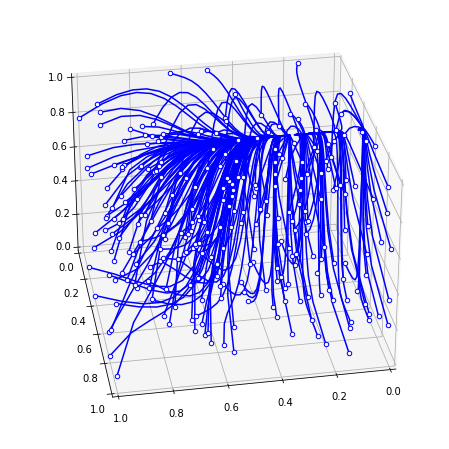

In [101]:
def gen_3D_dataset():
    # Plot results
    fig = plt.figure(figsize = (8,8))
    ax = plt.axes(projection='3d')
    m = 0 
    
    data = []
    for i in np.linspace(0.01,1.0,15):
        for j in np.linspace(0.01,1.0, 15):
            for k in np.linspace(0.01,1.0,15):

                p0 = [i, j, k]
                sol = odeint(multi_species_model,  p0, time_range, args = (N,gamma, sigma, mu, )).T
                
                m = np.random.randint(100)
                if m > 90:
                    
                    ax.plot(sol[0,:], sol[1,:], sol[2,:], c = "b")
                    ax.scatter3D(sol[0,0], sol[1,0], sol[2,0], c = "w", edgecolors = "b")
                    

                solution = np.array([sol[0,:], sol[1,:], sol[2,:]])
                data.append(solution)
                ax.set_xlim(0,1)
                ax.set_ylim(0,1)
                ax.set_zlim(0,1)
                
    ax.view_init(30, 80)
    data = np.array(data)
    return data

data = gen_3D_dataset()

In [104]:
# Convert to numpy array and print the structure
data = np.array(data)
data.shape

(3375, 3, 30)

In [105]:
np.save("./saved_sims/3_community.npy", data)

For even larger communities, the code is developed analogously. 

### Simulating Limit Cycle Dynamics

To simulate a limit cycle attractor in 2D, we consider a gLV model incorporating nonlinear interaction terms.

In [123]:
def lim(p,t,a,b, d):
    x, y = p
    dp = np.zeros(2)
    dp[0] =x*(1-x) - a*x*y/(d+x)
    dp[1] = b*y*(1-y/x)
    return dp

Define the simulation parameters:

In [124]:
tspan = np.linspace(0,20, 40)
r = np.array([1,0.5])
A = np.array([[1,    0.2],
             [0.5,    1]])
a = 1
d = 0.1
b = 0.20

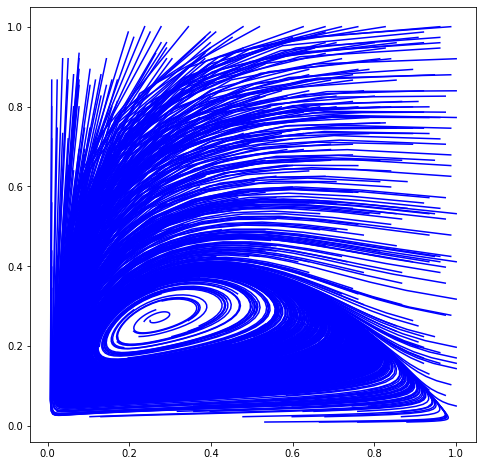

In [125]:
def gen_2D_dataset():
    # Plot results
    fig = plt.figure(figsize = (8,8))
    ax = fig.add_subplot(111)

    data = []
    for i in np.linspace(0.01,1.0, 75):
        for j in np.linspace(0.01,1.0, 75):

            p0 = [i, j]
            sol = odeint(lim, p0, tspan, args = (a,b,d,), rtol = 1e-5).T
            
            if np.random.randint(0,10) > 8:
                plt.plot(sol[0,:], sol[1,:], c = "b", )

            solution = np.array([sol[0,:], sol[1,:]])
            data.append(solution)
    
    return data

data = gen_2D_dataset()
plt.show()

In [126]:
# Convert to numpy array and print the structure
data = np.array(data)
data.shape

(5625, 2, 40)

In [127]:
np.save("./saved_sims/lim_community.npy", data)

#### Simulating Chaotic Dynamics

Lastly we generate chaotic dynamics.

In [128]:
def cycle(y,t,A):
    dydt =  -(1+y)*(A@y)
    return dydt

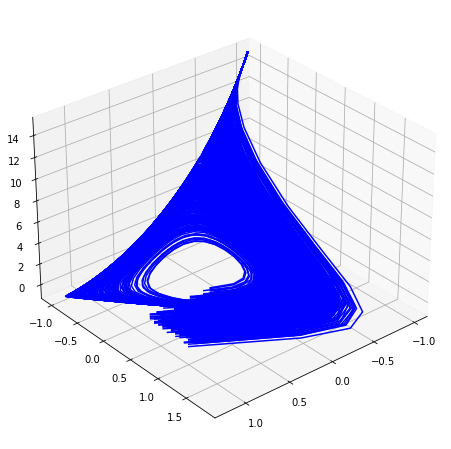

In [129]:
tspan = np.linspace(0, 20, 30)

A = np.array([[0.5,    0.5, 0.1],
             [-0.5,    -0.1,  0.1],
             [1.43,  0.1,  0.1 ]])

def gen_3D_dataset():
    # Plot results
    fig = plt.figure(figsize = (8,8))
    ax = plt.axes(projection='3d')
    m = 0 
    
    data = []
    for i in np.linspace(0.3,0.99,10):
        for j in np.linspace(0.3,0.99, 10):
            for k in np.linspace(0.3,0.99,10):

                yinit = [i, j, k]
                sol = odeint(cycle, yinit, tspan, args = (A,) ).T # t_eval=tspan, rtol = 1e-5)
                
                m = np.random.randint(100)
                if m > 50:
                    
                    ax.plot(sol[0,:], sol[1,:], sol[2,:], c = "b")                    

                solution = np.array([sol[0,:], sol[1,:], sol[2,:]])
                data.append(solution)

    ax.view_init(30, 50)
    data = np.array(data)
    return data

data = gen_3D_dataset()

In [130]:
# Convert to numpy array and print the structure
data = np.array(data)
data.shape

(1000, 3, 30)

In [131]:
np.save("./saved_sims/chaos_community.npy", data)